# 2022-09-15 • Two-pass connection test: peak-to-peak, then correlation with found average

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [6]:
using ProfileView

In [9]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [10]:
@time s = cached(sim, [p.sim]);

 12.469200 seconds (18.72 M allocations: 3.426 GiB, 7.63% gc time, 81.70% compilation time)


In [11]:
@profview s = augment(s, p);

In [13]:
using PyPlot
using VoltoMapSim.Plot

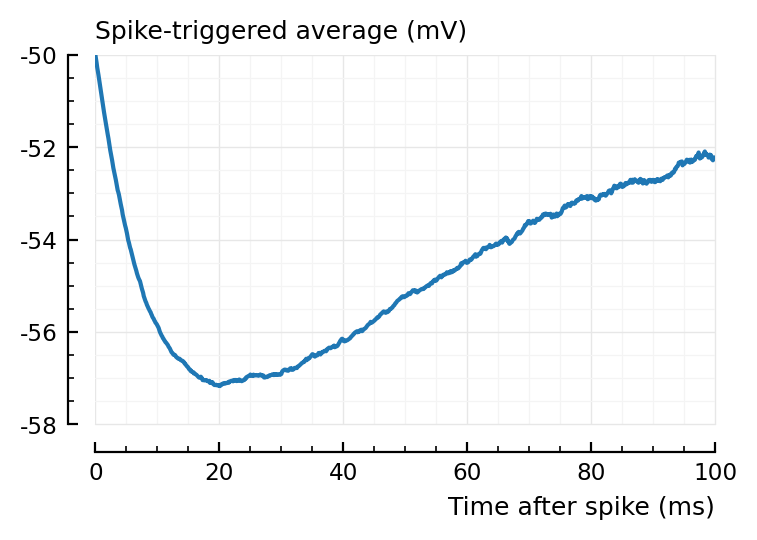

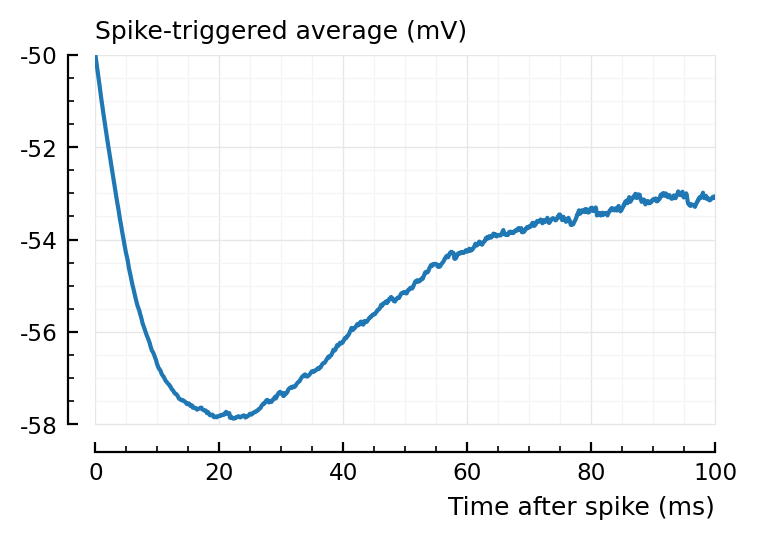

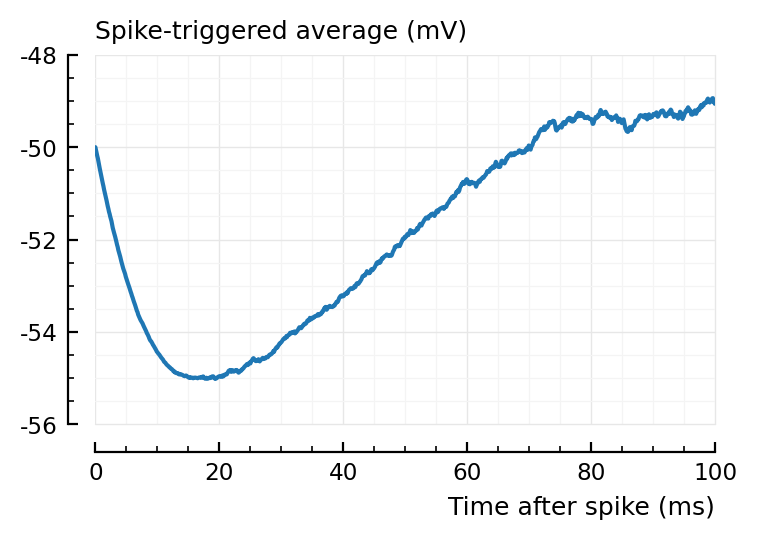

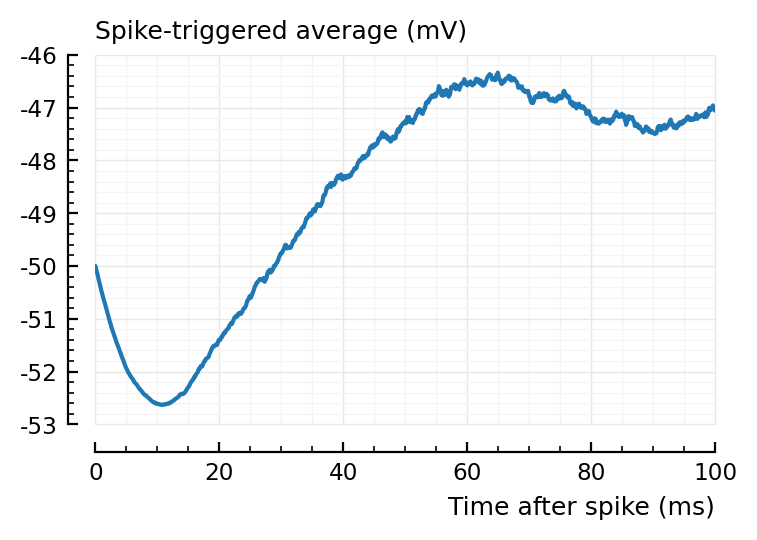

In [14]:
@profview plotSTA(1=>1,s,p);
plotSTA(2=>2,s,p);
plotSTA(801=>801,s,p);
plotSTA(802=>802,s,p);